In [209]:
%matplotlib inline
import csv, os, time, glob
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import combinations
np.set_printoptions(precision=4, suppress=True, linewidth=120)
from pandas.tseries.offsets import MonthEnd
import warnings
warnings.filterwarnings('ignore')
import math
from pandas_datareader.data import DataReader

In [210]:
def data_set_create(stock_list,data):
    temp_ = data[stock_list[0]]
    for i in range(1,len(list(stock_list))):
        temp_ = temp_.merge(data[stock_list[i]], left_on='Date', right_on='Date')

    temp_ = temp_.set_index('Date')
    return temp_


In [350]:
data_dir = "../indices/"
data_dir = "../indices_daily/"
data_dir = "../indices_quandl/"

files__ = pd.read_csv('../indices_details.csv')


sector_list_name =[]
sector_list =[]
for i in files__['Description'].unique():
    sector_list.append(list(files__['symbol'][files__['Description']==i]))
    sector_list_name.append(i)

In [351]:
files__['files']

0           US Corn Futures Historical Data (ZCN9)
1                        Rough Rice Futures (RRN9)
2                          US Wheat Futures (ZWN9)
3                    US Soybean Oil Futures (ZLN9)
4                       US Soybeans Futures (ZSN9)
5                               Oats Futures (Oc1)
6                       Live Cattle Futures (LEQ9)
7                 Lean Hogs Historical Data (HEM9)
8                     Feeder Cattle Futures (FCQ9)
9                   Class III Milk Futures (DCSc1)
10      Heating Oil Futures Historical Data (HON9)
11      Natural Gas Futures Historical Data (NGF8)
12    Crude Oil WTI Futures Historical Data (CLN9)
13                         Gas Oil Futures (LGOQ9)
14                             Gold Futures (GCQ9)
15                           Copper Futures (HGN9)
16                       Palladium Contract (PAU9)
17                           Silver Futures (SIN9)
18                         Platinum Futures (PLN9)
19                     US Sugar

In [352]:
sector_list

[['ZC', 'ZR', 'ZW', 'ZL', 'ZS', 'ZO'],
 ['LE', 'HE', 'FC', 'DC'],
 ['HO', 'NG', 'CL', 'QS'],
 ['GC', 'HG', 'PA', 'SI', 'PL'],
 ['SB', 'KC', 'CC', 'CT'],
 ['CAD_USD', 'JPY_USD', 'INR_USD', 'AUD_USD', 'GBP_USD'],
 ['BCOM', 'SPGSCITR', 'VIX', 'US500']]

In [263]:
# perm = combinations(list(files__['symbol']),4) 
# stock_list = list(perm)

In [264]:
# data ={}
# for i in list(files__['files']):
#     temp_= (pd.read_csv(data_dir+i+'.csv')[['Date','Price']].rename(columns={'Price':files__['symbol'][files__['files']==i].item()}))
#     temp_['Date'] =pd.to_datetime(temp_['Date'])
#     #temp_ = temp_.set_index('Date')
#     data[files__['symbol'][files__['files']==i].item()] = temp_

In [ ]:
data ={}

In [363]:
#for i in list(files__['files']):
for i in ['S&P 500 Contract (US500)']:
    temp_= pd.read_csv(data_dir+i+'.csv')[['Date','Price']]
    temp_['Date'] = pd.to_datetime(temp_['Date'])
    temp_ = temp_.set_index('Date')
    temp_= temp_.resample('1M', label='right').agg({files__['symbol'][files__['files']==i].item():'ohlc'})
    temp_ = temp_.fillna(method='ffill')
    temp_ = temp_[files__['symbol'][files__['files']==i].item()]['Price'][['close']]
    temp_ = temp_.rename(columns={'close':files__['symbol'][files__['files']==i].item()})
    temp_ = temp_.reset_index()      
    temp_['Date'] =pd.to_datetime(temp_['Date'])     
    #temp_ = temp_.set_index('Date')
    data[files__['symbol'][files__['files']==i].item()] = temp_

In [364]:
num_ =6
stock_list_to_analyse = sector_list[num_] # experimental 4 assets
dta = data_set_create(stock_list_to_analyse,data)

In [365]:
#1990-01-31

In [366]:
for i in stock_list_to_analyse:
    print(data[i].head(1))

        Date    BCOM
0 1991-01-31  94.409
        Date  SPGSCITR
0 1980-01-31    727.92
        Date    VIX
0 1990-01-31  25.36
        Date  US500
0 1982-04-30  117.5


In [367]:
stock_list_to_analyse

['BCOM', 'SPGSCITR', 'VIX', 'US500']

In [368]:
dta.head()

,BCOM,SPGSCITR,VIX,US500
Date,,,,
1991-01-31,94.409,2212.4629,20.91,344.65
1991-02-28,95.903,2243.2271,21.23,366.80
1991-03-31,96.125,2327.6660,16.88,376.25
1991-04-30,96.055,2380.3889,18.24,375.90
1991-05-31,94.557,2379.1699,15.93,389.70


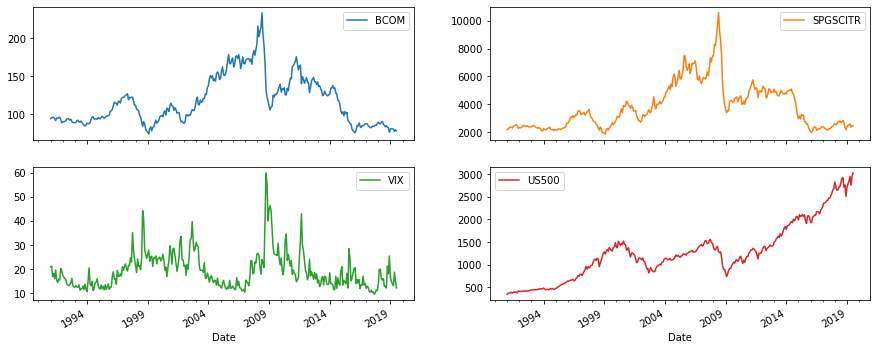

In [369]:
dta.loc[:, stock_list_to_analyse[0]:stock_list_to_analyse[len(stock_list_to_analyse)-1]].plot(subplots=True, layout=(math.ceil(len(stock_list_to_analyse)/2),2), figsize=(15, 6));

In [370]:
for i in stock_list_to_analyse:
    # Create log-differenced series
    dta['dln_'+i] = (np.log(dta[i])).diff() * 100
    # De-mean and standardize
    dta['std_'+i] = (dta['dln_'+i] - dta['dln_'+i].mean()) / dta['dln_'+i].std()
    
    
start_date =dta.index[0]
dta_ =dta.index
dta = dta.dropna()

In [371]:
spike_cols = [col for col in dta.columns if 'std_' in col]
spike_cols_1 = [col for col in dta.columns if 'dln_' in col]

In [372]:
endog = dta[spike_cols]

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)#, enforce_stationarity=False)

initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params)

In [373]:
print(res.summary(separate_params=False))

                                            Statespace Model Results                                            
Dep. Variable:     ['std_BCOM', 'std_SPGSCITR', 'std_VIX', 'std_US500']   No. Observations:                  342
Model:                                DynamicFactor(factors=1, order=2)   Log Likelihood               -1619.837
                                                         + AR(2) errors   AIC                           3275.674
Date:                                                  Sun, 28 Jul 2019   BIC                           3344.701
Time:                                                          18:01:22   HQIC                          3303.172
Sample:                                                      02-28-1991                                         
                                                           - 07-31-2019                                         
Covariance Type:                                                    opg                         

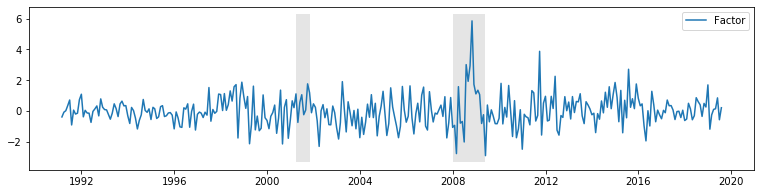

In [374]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

# Retrieve and also plot the NBER recession indicators
rec = DataReader('USREC', 'fred', start=endog.index[0], end=endog.index[endog.shape[0]-1])
ylim = ax.get_ylim()
ax.fill_between(dates[:len(rec)], ylim[0], ylim[1], rec.values[:,0], facecolor='k', alpha=0.1);

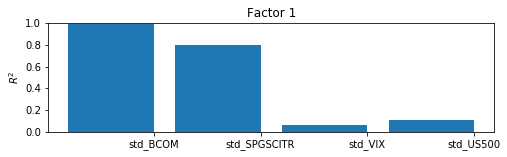

In [375]:
res.plot_coefficients_of_determination(figsize=(8,2));

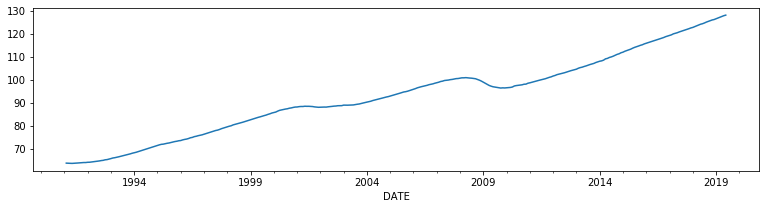

In [376]:
usphci = DataReader('USPHCI', 'fred', start=start_date-pd.Timedelta(days=0), end=endog.index[endog.shape[0]-1])['USPHCI']
usphci.index = pd.to_datetime(usphci.index, format="%Y%m") + MonthEnd(1)
usphci.plot(figsize=(13,3));

In [377]:
dusphci = usphci.diff()[1:].values
def compute_coincident_index(mod, res):
    # Estimate W(1)
    spec = res.specification
    design = mod.ssm['design']
    transition = mod.ssm['transition']
    ss_kalman_gain = res.filter_results.kalman_gain[:,:,-1]
    k_states = ss_kalman_gain.shape[0]

    W1 = np.linalg.inv(np.eye(k_states) - np.dot(
        np.eye(k_states) - np.dot(ss_kalman_gain, design),
        transition
    )).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = np.dot(W1, dta[spike_cols_1].mean())
    
    # Normalize the factors
    factor = res.factors.filtered[0]
    factor *= np.std(usphci.diff()[1:]) / np.std(factor)

    # Compute the coincident index
    coincident_index = np.zeros(mod.nobs+1)
    # The initial value is arbitrary; here it is set to
    # facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, mod.nobs):
        coincident_index[t+1] = coincident_index[t] + factor[t] + factor_mean
    
    # Attach dates
    coincident_index = pd.Series(coincident_index, index=dta_).iloc[1:]
    
    # Normalize to use the same base year as USPHCI
    coincident_index *= (usphci.loc['1992-07-31'] / coincident_index.loc['1992-07-31'])
    #coincident_index *= (usphci.loc['2010-07-31'] / coincident_index.loc['2010-07-31'])
    
    return coincident_index

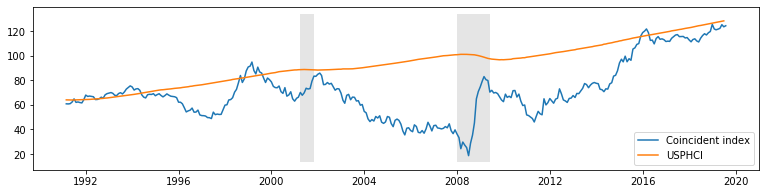

In [378]:
fig, ax = plt.subplots(figsize=(13,3))

# Compute the index
coincident_index = compute_coincident_index(mod, res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index, label='Coincident index')
ax.plot(usphci.index._mpl_repr(), usphci, label='USPHCI')
ax.legend(loc='lower right')

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:len(rec)], ylim[0], ylim[1], rec.values[:,0], facecolor='k', alpha=0.1);

In [379]:
pd.Series(coincident_index,name="value").to_frame().to_csv('../indices_quandl/indices/'+sector_list_name[num_]+'.csv')

In [380]:
sector_list_name[num_]

'EXCHANGE'